In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pystan
import random
import pandas as pd
import statistics as st
from collections import Counter
import os
import seaborn as sns
sns.set()

### load the data

In [43]:
# load the data
co2_data = pd.read_csv('co2.csv')
co2_data.head()

,date,ppm
0,3/29/58,316.19
1,4/5/58,317.31
2,4/12/58,317.69
3,4/19/58,317.58
4,4/26/58,316.48


### convert weeks to days

In [0]:
days_passed = np.arange(0,21631,7)
weeks_passed = np.arange(0,3091,1)

In [5]:
print(len(days_passed))
print(len(co2_data))
print(len(weeks_passed))

3091
3091
3091


In [7]:
co2_data['days_passed'] = days_passed
co2_data['weeks_passed'] = weeks_passed
co2_data.drop('date', axis =1)
co2_data = co2_data[['days_passed', 'weeks_passed','ppm']]
co2_data.head()

,days_passed,weeks_passed,ppm
0,0,0,316.19
1,7,1,317.31
2,14,2,317.69
3,21,3,317.58
4,28,4,316.48


### plot the raw data

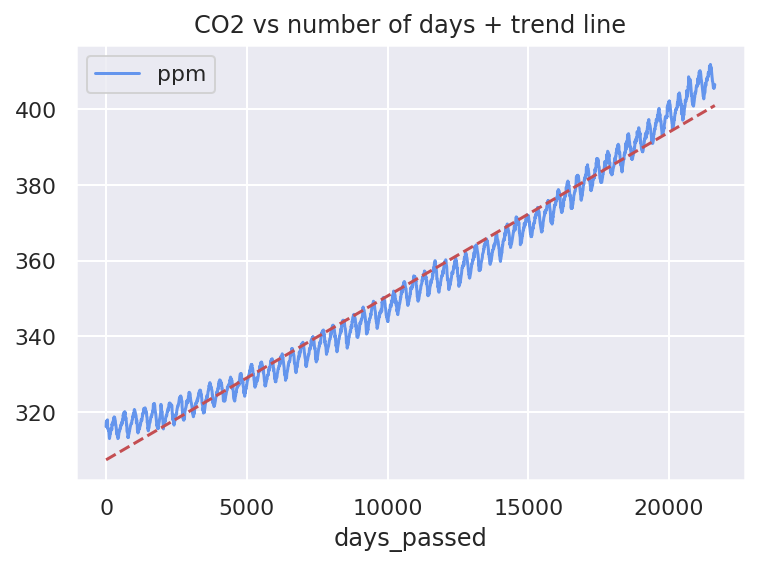

In [8]:
co2_data.plot(kind='line',x='days_passed',y='ppm',color='cornflowerblue')

z = np.polyfit(co2_data['days_passed'], co2_data['ppm'], 1)
p = np.poly1d(z)
plt.plot(co2_data['days_passed'],p(co2_data['days_passed']),"r--")

plt.title('CO2 vs number of days + trend line')
plt.show()

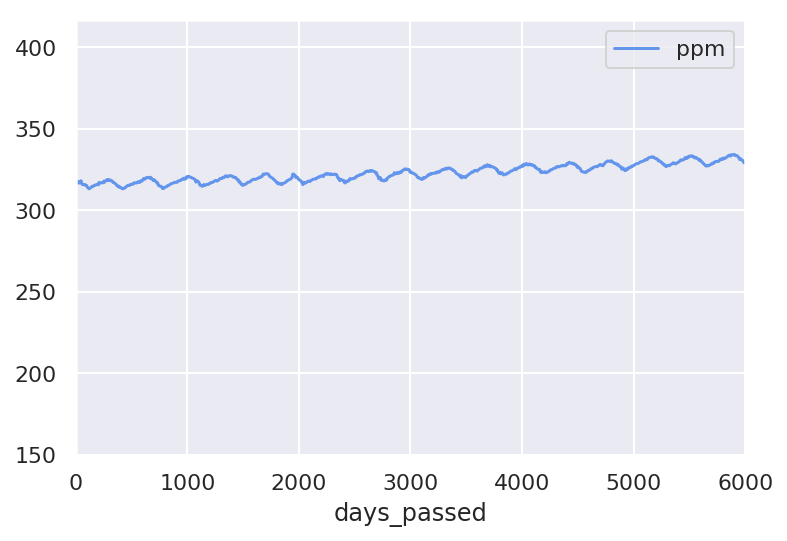

In [9]:
co2_data.plot(kind='line',x='days_passed',y='ppm',color='cornflowerblue')
plt.xlim(0, 6000)
plt.ylim(150,)
plt.show()

### Stan model

In [18]:
stan_code = '''
data {
    int<lower=0> n;                 // number of observation
    real<lower=0> ppm[n];           // ppm levels
    int<lower=0> days_passed[n];    // number of days
    int<lower=0> n_future;          // number of future values to predict
}

parameters {
    real<lower=0> c0;    // 
    real<lower=0> c1;    // 
    real<lower=0> c2;    // quadratic term
    real<lower=0> c3;    // amplitude
    real c4_x;           // phase shift
    real c4_y;           // phase shift
    real sigma;          // noise
}

transformed parameters {
    real<lower=0, upper=1> c4;
    c4 = atan2(c4_x, c4_y) / (2 * pi()) + 0.5;
    
}
model {
    c0 ~ normal(315,10);      //
    c1 ~ normal(1, 0.5);        //
    c2 ~ normal(0.01,0.01);   // quadratic
    c3 ~ gamma(1, 0.5);       // amplitude
    c4_x ~ normal(0, 1);      // amplitude
    c4_y ~ normal(0, 1);      // phase shift
    sigma ~ gamma(1, 0.5);    // noise

   for(t in 1:n) {
        ppm[t] ~ normal(
        c0+c1*t+(c2*t)^2+c3*cos(2*pi()*t/365.25+c4),
        sigma);
    }
}

// generate future predictions
generated quantities{
    real x_future[n_future];
    for(t in 1:n_future) {
        x_future[t] = normal_rng(
            c0+c1*(t+n)+(c2*t)^2+c3*cos(2*pi()*(t+n)/365.25+c4),
            sigma);
    }
}
'''

In [19]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1112e1d3e236808457c72e9a21178ddc NOW.


In [20]:
ppm_values = co2_data['ppm'].values.flatten()
days_passed_values = co2_data['days_passed'].values.flatten()

stan_data = {
    "n": len(co2_data),
    "ppm": ppm_values,
    "days_passed": days_passed_values,
    'n_future': len(ppm_values)
}

In [21]:
type(days_passed_values)

numpy.ndarray

In [22]:
results = stan_model.sampling(data=stan_data)

/ext/anaconda5/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [25]:
#parameters of interest
parameters = ['c0', 'c1', 'c2', 'c3', 'c4_x', 'c4_y', 'sigma']

In [26]:
print(results.stansummary(pars = parameters, probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_1112e1d3e236808457c72e9a21178ddc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
c0    307.41  2.3e-3   0.15 307.12  307.4 307.69   4000    1.0
c1      0.03  1.3e-6 8.2e-5   0.03   0.03   0.03   4000    nan
c2      0.01  2.2e-4 8.1e-3 6.5e-4   0.01   0.03   1343    1.0
c3      0.04  1.2e-3   0.04 6.2e-4   0.03   0.16   1333    1.0
c4_x   -0.33    0.03    0.9  -2.04  -0.35   1.65   1153   1.01
c4_y   -0.28    0.03   1.01  -2.17  -0.34   1.77   1351    1.0
sigma   4.04  1.2e-3   0.05   3.94   4.03   4.13   1669    1.0

Samples were drawn using NUTS at Fri Dec 21 07:22:22 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [32]:
samples = results.extract()

In [33]:
n = len(ppm_values)
n_future = len(ppm_values)

In [34]:
means = [np.mean(samples['x_future'][:,i]) for i in range(0,n)]
means[3090]

494.60417438193286

In [35]:
mm = range(n, n + n_future)
len(means)

3091

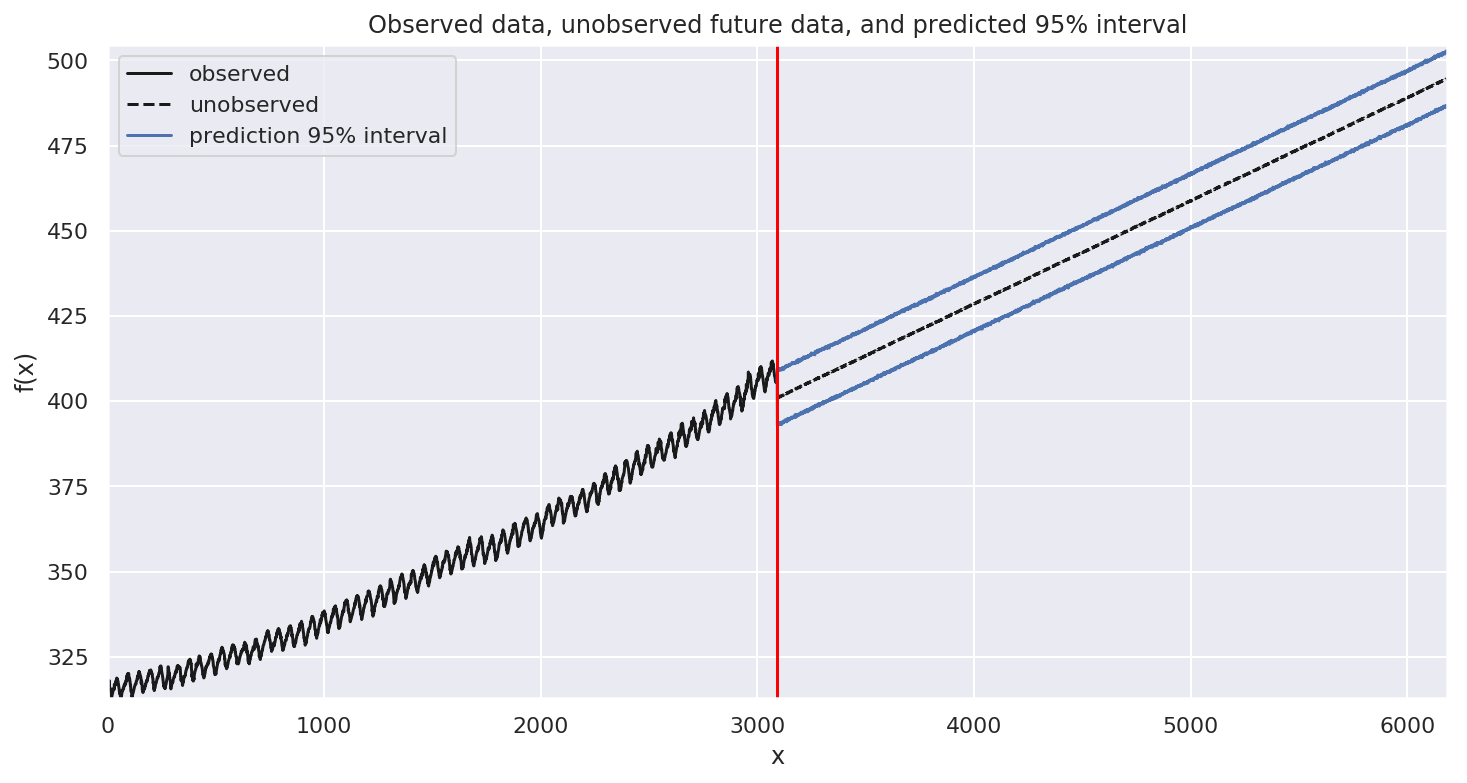

In [36]:
prediction = samples['x_future']

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(range(1, n + 1), ppm_values[:n], 'k-', label='observed')
plt.plot(range(n, n + n_future), means, 'k--', label='unobserved')
plt.xlim(0, n + n_future + 1)
plt.ylim(
    min(min(prediction[0,:]), min(ppm_values)),
    max(max(prediction[1,:]), max(ppm_values)))
plt.plot(
    range(n, n + n_future+1),
    np.concatenate((ppm_values[-1:], prediction_interval[0,:])),
    'b-', label='prediction 95% interval')
plt.plot(
    range(n, n + n_future+1),
    np.concatenate((ppm_values[-1:], prediction_interval[1,:])),
    'b-')
plt.axvline(n - 1, color='red')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

### plot auto-cor plots

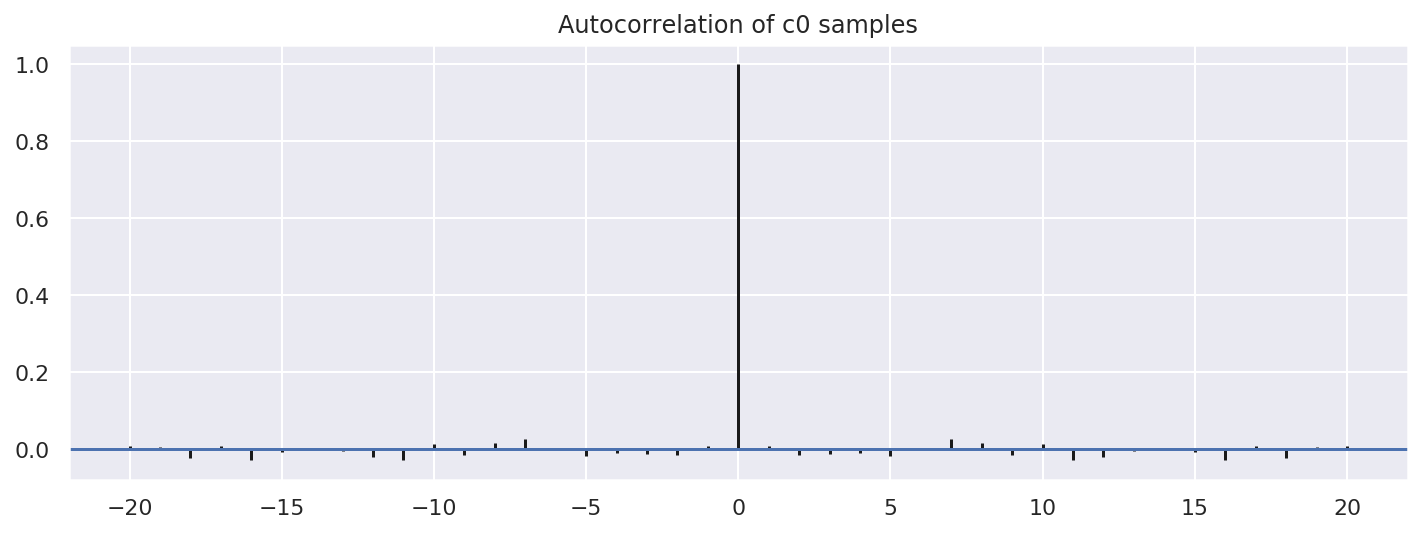

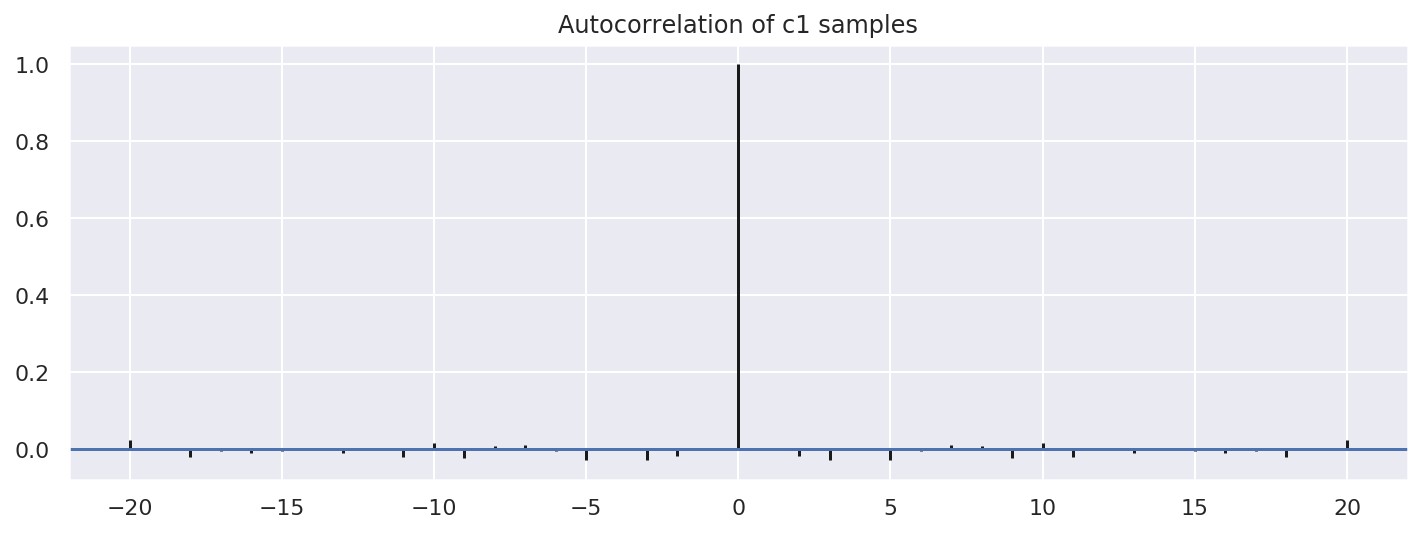

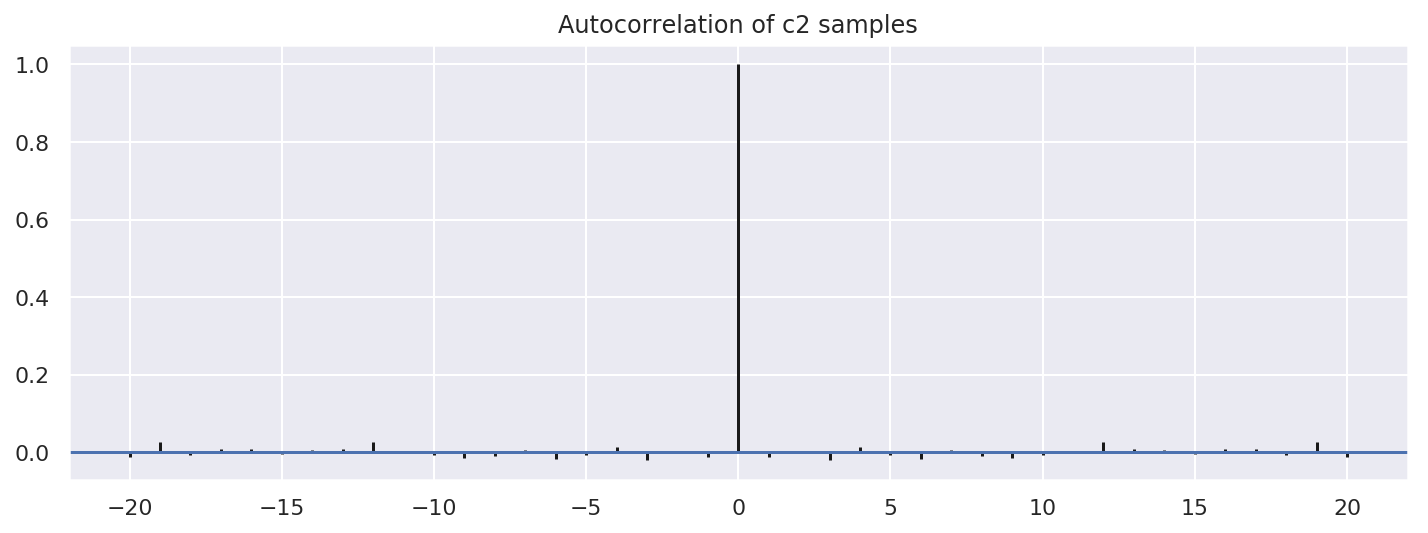

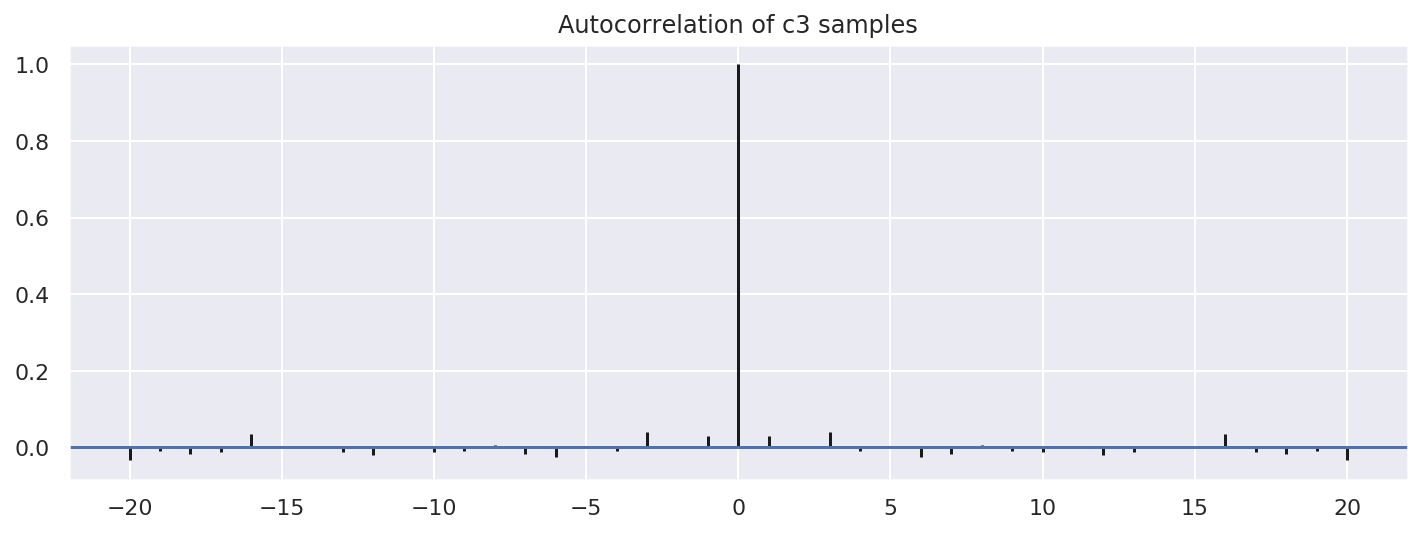

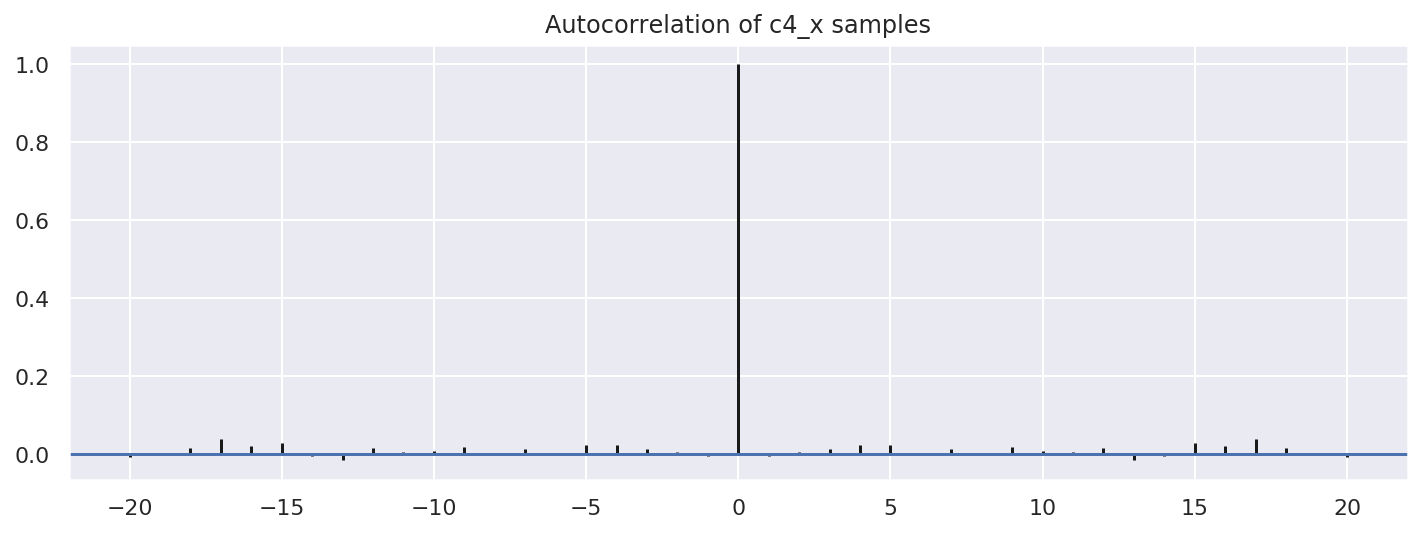

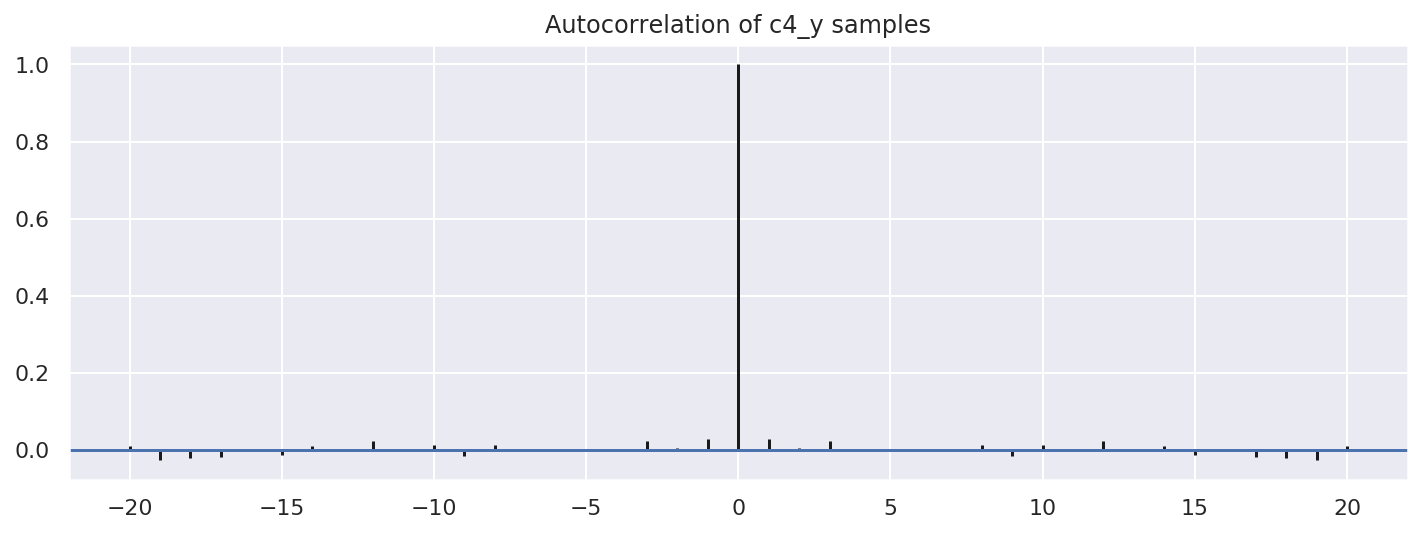

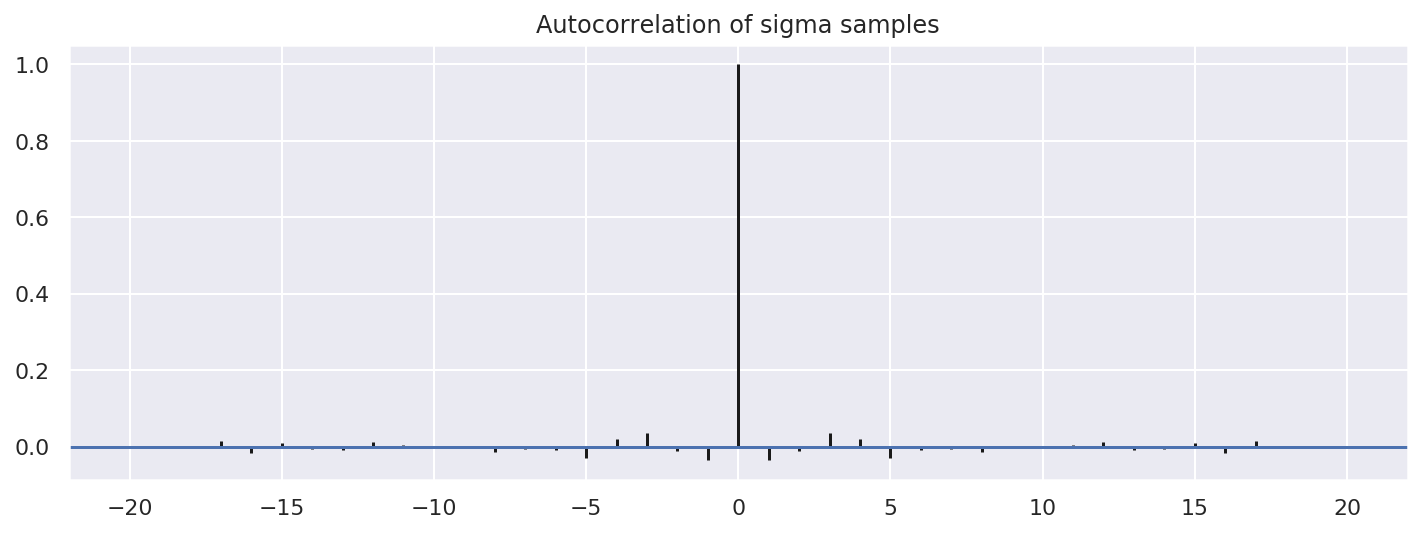

In [38]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


    
    
for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

### plot pair plots

/ext/anaconda5/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


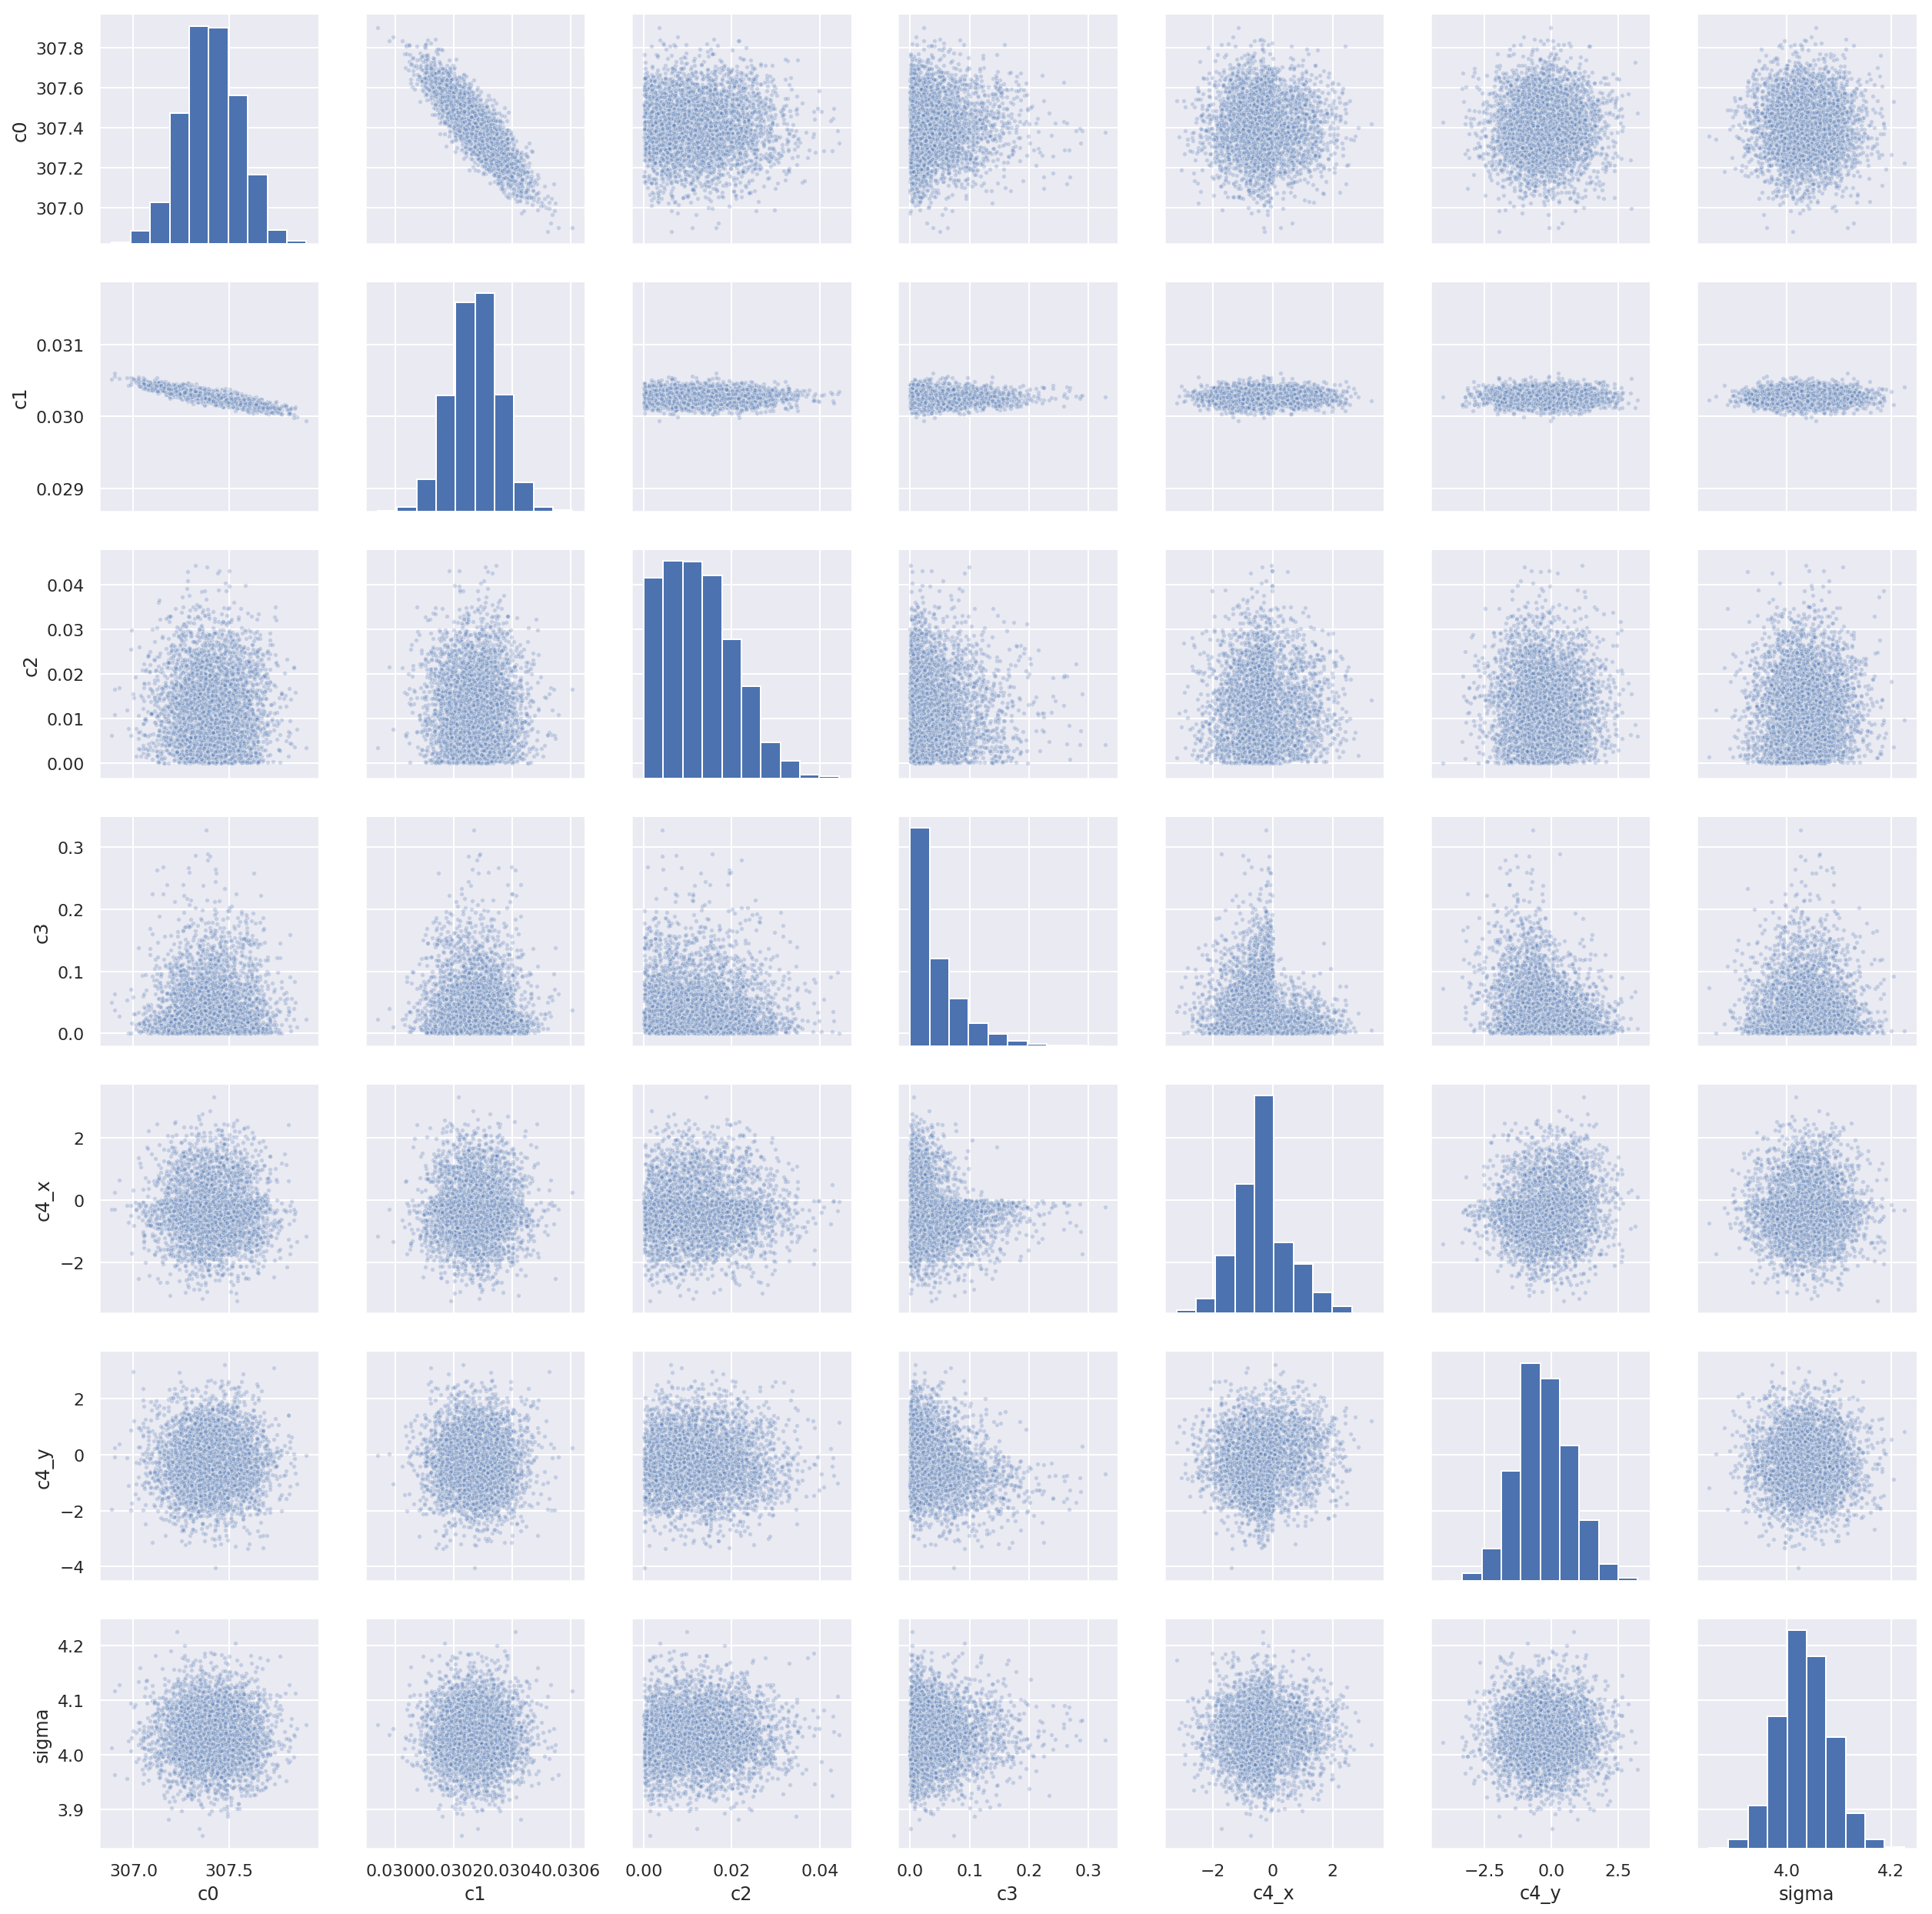

In [39]:
# Make pair plot of the posteriors over all the parameters
# Code reference: 14.1 Preclass work 3
pair_data = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
sns.pairplot(pair_data, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()